In [47]:
import sys
import os
import time
import datetime

import numpy as np
import pandas as pd
import scipy
import glob

import serial
from serial.tools import list_ports

import matplotlib.pyplot as plt

# ポートは必ず、開けたら閉じること！

# Arduinoのシリアルボードと同時には動かせないかも？

In [202]:
# どのポートが接続されているかを確認する
ports = list_ports.comports()    # ポートデータを取得
devices = [info.device for info in ports]
print(devices)

['COM3']


In [203]:
ser.close()

NameError: name 'ser' is not defined

In [204]:
# Arduino側の設定_210531
# 8ch分のアナログデータが送信されるので、それを受信する感じで
# プロトコル(STX)は、1111で、続いてArduino_Srial.millis()で計測した時刻情報が来る
# 時刻は、100ms単位で累積表示：誤差は1%くらいあるので諦める。(10msくらいまでは下げられそう)
# プロトコル(ETX)は、改行している(Arduino_Serial.println())ので、行終端までを取得していく感じでいい

#

In [215]:
# エラー処理でポート閉じてほしい

def main(sampling_rate, bit_rate, meas_time):
    print("データ取得中です・・・")
    i = 0
    ser = serial.Serial("COM3", bit_rate)  # Arduinoが接続されているコムポートを指定   #timeout = 0.1
    #ser.parity = serial.PARITY_ODD
    list_t = []
    list = []
    #T1 = time.time()
    T1 = time.perf_counter()
    
    # 受信のはじめの1回は取得しない
    line = ser.readline()   # 行終端まで読み込む
    
    for i in range(meas_time):
    #while(i != meas_time):
        
        
        # シリアル受信の取得と整形
        line = ser.readline()   # 行終端まで読み込む
        line = line.rstrip().decode("UTF-8")   # 行終端コード削除
        
        #print(line)
        list.append(line.split(","))
        #list.append(line[2:-5].split(","))
        
        # 時刻情報の取得(pythonのtime.perf_counterで実装している)→arduino側でラベルつけるべきかも。。
        list_t.append(round(time.perf_counter() - T1, 6))
        
        
        #todaydetail = datetime.datetime.today()
        #line = ser.read_all()    #たぶんいらない
        
        #print(str(line), "[V]")
        #print(todaydetail.strftime("%Y/%m/%d %H:%M:%S"), " > ", str(line), " [V]")
        #i+=1
        
        # ここが実質サンプリングレートになる
        # これでは正確じゃないから、別の手段を選ぶべき
        #time.sleep(sampling_rate)
        
    ser.close()
    #ser.parity = serial.PARITY_NONE
    print("データ取得完了！")
    print(T1)
    list_t2 = np.array(list_t)-T1
    
    return list, list_t, list_t2

In [216]:
%%time
if __name__ == "__main__":
    
    # 初期設定
    sampling_rate = 0.1    # サンプリングレート[sec]
    bit_rate = 115200    #(9600, 19200, 38400, 57600, 74880, 115200)
    meas_time = 60
    
    # メイン処理(arduinoからの、シリアル受信)
    report_meas, list_t, list_t2 = main(sampling_rate, bit_rate, meas_time)
    
    print(str(len(report_meas)))
    print(str(len(list_t)))

データ取得中です・・・
データ取得完了！
45290.3948257
60
60
Wall time: 7.87 s


In [217]:
list_null = 0

In [218]:
df_time = pd.DataFrame(list_t[list_null:], columns=["time"])
#df_time.head(50)

# pythonの計測時刻を確認する・・・100msでの取得で、10%くらいありそう、Arduinoは100msなら1%くらい
df_time_dif = df_time.diff(1)
df_time_dif.head(50)

,time
0,NaN
1,0.096742
2,0.095441
3,0.111150
4,0.096564
5,0.093669
6,0.112574
7,0.096931
8,0.096145
9,0.108191


In [219]:
# よくわからないけど、シリアル受信の最初だけ、空が3回来るから除去する
report_meas_a = report_meas[list_null:]
print("取得サンプル数：", str(len(report_meas_a)), " 個\n")
#print(report_meas_a) 

取得サンプル数： 60  個



In [221]:
col_name = ["STX", "time_arduino", "A0","A1","A2","A3","A4","A5","A6","A7"]
df_samples = pd.DataFrame(report_meas_a, columns = col_name)
df_samples.head(10)

,STX,time_arduino,A0,A1,A2,A3,A4,A5,A6,A7
0,1111,202,3.20,3.37,3.36,3.22,2.99,2.76,2.61,2.37
1,1111,303,2.79,2.84,2.92,2.92,2.85,2.73,2.61,2.38
2,1111,404,1.21,1.46,1.70,1.88,2.05,2.12,2.12,2.06
3,1111,505,0.75,0.77,0.88,1.04,1.28,1.47,1.58,1.67
4,1111,606,0.65,0.66,0.71,0.78,0.94,1.11,1.25,1.36
5,1111,707,0.48,0.53,0.57,0.60,0.71,0.83,0.95,1.08
6,1111,808,0.39,0.46,0.51,0.54,0.62,0.70,0.79,0.89
7,1111,909,0.31,0.40,0.47,0.50,0.57,0.63,0.70,0.78
8,1111,1010,0.32,0.43,0.49,0.53,0.60,0.65,0.71,0.77
9,1111,1111,0.41,0.47,0.53,0.57,0.62,0.67,0.73,0.78


In [228]:
# 時間情報を追加する
df = pd.concat([df_time, df_samples], axis=1)
df = df.astype("float64")
print(df.shape)
df.head(50)

(60, 11)


,time,STX,time_arduino,A0,A1,A2,A3,A4,A5,A6,A7
0,1.789105,1111.0,202.0,3.20,3.37,3.36,3.22,2.99,2.76,2.61,2.37
1,1.885847,1111.0,303.0,2.79,2.84,2.92,2.92,2.85,2.73,2.61,2.38
2,1.981288,1111.0,404.0,1.21,1.46,1.70,1.88,2.05,2.12,2.12,2.06
3,2.092438,1111.0,505.0,0.75,0.77,0.88,1.04,1.28,1.47,1.58,1.67
4,2.189002,1111.0,606.0,0.65,0.66,0.71,0.78,0.94,1.11,1.25,1.36
5,2.282671,1111.0,707.0,0.48,0.53,0.57,0.60,0.71,0.83,0.95,1.08
6,2.395245,1111.0,808.0,0.39,0.46,0.51,0.54,0.62,0.70,0.79,0.89
7,2.492176,1111.0,909.0,0.31,0.40,0.47,0.50,0.57,0.63,0.70,0.78
8,2.588321,1111.0,1010.0,0.32,0.43,0.49,0.53,0.60,0.65,0.71,0.77
9,2.696512,1111.0,1111.0,0.41,0.47,0.53,0.57,0.62,0.67,0.73,0.78


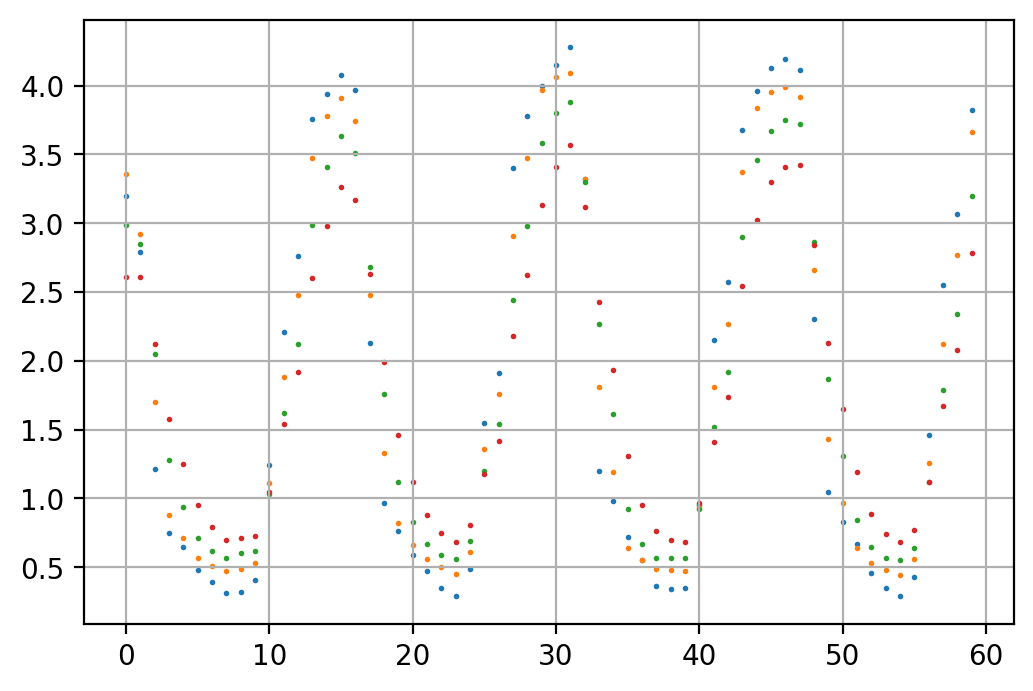

In [234]:
st = 0
fi = 300

fig = plt.figure(dpi=200)
plt.scatter(np.arange(len(df["A0"][st:fi])), df["A0"][st:fi], s=1)
plt.scatter(np.arange(len(df["A2"][st:fi])), df["A2"][st:fi], s=1)
plt.scatter(np.arange(len(df["A4"][st:fi])), df["A4"][st:fi], s=1)
plt.scatter(np.arange(len(df["A6"][st:fi])), df["A6"][st:fi], s=1)

#plt.scatter(np.arange(len(df)), df["A1"], s=1)
#plt.scatter(df["time"], df["time"], s=1)
plt.grid()